In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats import zscore, linregress
from pandas.plotting import scatter_matrix
from scipy import stats
import numpy as np

In [79]:
# # Function to remove outliers from a dataframe
# from sklearn.neighbors import LocalOutlierFactor


# def remove_outliers(df):
#     # Initialize a boolean mask to keep track of rows to drop
#     outlier_rows_mask = np.zeros(len(df), dtype=bool)

#     # Iterate over each column
#     for col in df.columns:
#         # Skip the "t1" and "t2" columns
#         if col == "t1" or col == "t2":
#             continue

#         # Fit the LocalOutlierFactor model to the column data
#         lof = LocalOutlierFactor()
#         outliers = lof.fit_predict(df[col].values.reshape(-1, 1))

#         # Mark rows with outliers in this column
#         outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers == -1)

#     # Drop rows with outliers
#     cleaned_df = df[~outlier_rows_mask]
#     return cleaned_df


def remove_outliers(df, threshold=2):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Skip the "t1" and "t2" columns
        if col == "t1" or col == "t2":
            continue

        # Calculate the mean and standard deviation of the column
        mean = df[col].mean()
        std = df[col].std()

        # Find outliers in this column
        outliers = (df[col] - mean).abs() > threshold * std

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers)

    # Drop rows with outliers
    cleaned_df = df[~outlier_rows_mask]
    return cleaned_df

In [3]:
fluxnet_info = pd.read_csv("../data/EC/fluxnet/sites_info.csv")
ameriflux_info = pd.read_csv("../data/EC/Ameriflux/sites_info.tsv", delimiter="\t")
fluxnet_names = fluxnet_info["ID"].to_list()
fluxnet_types = fluxnet_info["type"].to_list()
ameriflux_names = ameriflux_info["Site ID"].to_list()
ameriflux_types = ameriflux_info["Vegetation Abbreviation (IGBP)"].to_list()

In [4]:
combined_names = list(set(ameriflux_names + fluxnet_names))
combined_types = []
for name in combined_names:
    if name in ameriflux_names and name in fluxnet_names:
        # Choose a type from either fluxnet_types or ameriflux_types
        combined_types.append(fluxnet_types[fluxnet_names.index(name)])
    elif name in ameriflux_names:
        combined_types.append(ameriflux_types[ameriflux_names.index(name)])
    else:
        combined_types.append(fluxnet_types[fluxnet_names.index(name)])

In [5]:
dfs = []

# Iterate over the range of length of 'name' column in sites_info
for i in range(len(combined_names)):
    site_name = combined_names[i]
    site_type = combined_types[i]

    # Set the file path based on whether the combined name is in ameriflux_names or fluxnet_names
    if site_name in ameriflux_names:
        file = glob.glob("../data/EC/Ameriflux/AMF_" + site_name + "*WW*")
    else:
        file = glob.glob("../data/EC/fluxnet/FLX_" + site_name + "*WW*")

    # Open the CSV file
    ec = pd.read_csv(file[0])
    ec.loc[:, "type"] = site_type
    ec.loc[:, "name"] = site_name

    ec["t1"] = pd.to_datetime(ec["TIMESTAMP_START"], format="%Y%m%d")
    ec["t2"] = pd.to_datetime(ec["TIMESTAMP_END"], format="%Y%m%d")

    # Append the DataFrame to the list
    dfs.append(ec)

# Concatenate all DataFrames in the list
combined_ec = pd.concat(dfs)

In [7]:
MCD43_fluxnet = []
MCD15_fluxnet = []
MCD43_ameriflux = []
MCD15_ameriflux = []

# Loop over batches (#5) of downloaded data
for i in range(1, 5):
    refl_fluxnet = glob.glob(
        "../data/EC/fluxnet/sat_data/*batch" + str(i) + "*MCD43A4-061-results.csv"
    )
    sat_refl_fluxnet = pd.read_csv(refl_fluxnet[0])
    sat_refl_fluxnet.loc[:, "time"] = pd.to_datetime(sat_refl_fluxnet["Date"])
    sat_refl_fluxnet.set_index(sat_refl_fluxnet["Date"], inplace=True)
    MCD43_fluxnet.append(sat_refl_fluxnet)

    fpar_fluxnet = glob.glob(
        "../data/EC/fluxnet/sat_data/*batch" + str(i) + "*MCD15A3H-061-results.csv"
    )
    sat_fpar_fluxnet = pd.read_csv(fpar_fluxnet[0])
    sat_fpar_fluxnet.loc[:, "time"] = pd.to_datetime(sat_fpar_fluxnet["Date"])
    sat_fpar_fluxnet.set_index(sat_fpar_fluxnet["Date"], inplace=True)
    MCD15_fluxnet.append(sat_fpar_fluxnet)

    if i < 5:
        refl_ameriflux = glob.glob(
            "../data/EC/Ameriflux/sat_data/*batch" + str(i) + "*MCD43A4-061-results.csv"
        )

        sat_refl_ameriflux = pd.read_csv(refl_ameriflux[0])
        sat_refl_ameriflux.loc[:, "time"] = pd.to_datetime(sat_refl_ameriflux["Date"])
        sat_refl_ameriflux.set_index(sat_refl_ameriflux["Date"], inplace=True)
        MCD43_ameriflux.append(sat_refl_ameriflux)

        fpar_ameriflux = glob.glob(
            "../data/EC/Ameriflux/sat_data/*batch"
            + str(i)
            + "*MCD15A3H-061-results.csv"
        )
        fpar_ameriflux = pd.read_csv(fpar_ameriflux[0])

        fpar_ameriflux.loc[:, "time"] = pd.to_datetime(fpar_ameriflux["Date"])
        fpar_ameriflux.set_index(fpar_ameriflux["Date"], inplace=True)
        MCD15_ameriflux.append(fpar_ameriflux)


refl_fluxnet = pd.concat(MCD43_fluxnet)
refl_fluxnet = refl_fluxnet.rename(columns={"ID": "name"})

fpar_fluxnet = pd.concat(MCD15_fluxnet)
fpar_fluxnet = fpar_fluxnet.rename(columns={"ID": "name"})

refl_ameriflux = pd.concat(MCD43_ameriflux)
refl_ameriflux = refl_ameriflux.rename(columns={"ID": "name"})
fpar_ameriflux = pd.concat(MCD15_ameriflux)
fpar_ameriflux = fpar_ameriflux.rename(columns={"ID": "name"})
combined_refl = []
combined_fpar = []

for name in combined_names:
    if name in ameriflux_names:
        selected_refl = refl_ameriflux[refl_ameriflux["name"] == name]
        selected_fpar = fpar_ameriflux[fpar_ameriflux["name"] == name]
    else:
        selected_refl = refl_fluxnet[refl_fluxnet["name"] == name]
        selected_fpar = fpar_fluxnet[fpar_fluxnet["name"] == name]

    combined_refl.append(selected_refl)
    combined_fpar.append(selected_fpar)

combined_refl = pd.concat(combined_refl)
combined_fpar = pd.concat(combined_fpar)

In [80]:
bad_sites_list = []
good_sites_list = []


for i in range(len(combined_names)):
    # for i in range(2, 6):
    print(i)
    site_name = combined_names[i]
    site_type = combined_types[i]
    site_ec = combined_ec[combined_ec["name"] == site_name]
    site_refl = combined_refl[combined_refl["name"] == site_name]
    site_fpar = combined_fpar[combined_fpar["name"] == site_name]
    if site_ec["PPFD_IN_QC"].isna().all():
        print("No PPFD data for " + site_name)
        bad_sites_list.append(site_name)
        continue
    gpp = site_ec[["GPP_NT_VUT_REF"]]
    par = site_ec[["PPFD_IN"]]
    par_qc = site_ec[["PPFD_IN_QC"]]
    time1 = site_ec[["t1"]]
    time2 = site_ec[["t2"]]
    ec_weekly = pd.concat([time1, time2, gpp, par, par_qc], axis=1).rename(
        columns={"GPP_NT_VUT_REF": "gpp", "PPFD_IN": "par", "PPFD_IN_QC": "par_qc"}
    )
    ec_weekly = ec_weekly[ec_weekly["par_qc"] == 1]
    ec_weekly = ec_weekly[ec_weekly["gpp"] != -9999]
    ec_weekly.drop(columns=["par_qc"], inplace=True)
    if ec_weekly.empty:
        print("No data for " + site_name)
        bad_sites_list.append(site_name)
        continue

    site_fpar_filtered = site_fpar[
        (site_fpar["MCD15A3H_061_FparLai_QC_MODLAND"] == "0b0")
        & (site_fpar["MCD15A3H_061_FparLai_QC_DeadDetector"] == "0b0")
        & (site_fpar["MCD15A3H_061_FparLai_QC_CloudState"] == "0b00")
        & (site_fpar["MCD15A3H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
    ]
    site_fpar_filtered.index = pd.to_datetime(site_fpar_filtered.index)

    site_refl_filtered = site_refl[
        (
            site_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band1_MODLAND"]
            == "0b000"
        )
        & (
            site_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band2_MODLAND"]
            == "0b000"
        )
    ]

    site_refl_filtered.index = pd.to_datetime(site_refl_filtered.index)
    resampled_fpar = []
    resampled_refl = []

    for idx, row in ec_weekly.iterrows():
        # Select the data for the current week
        t1 = pd.to_datetime(row["t1"])
        t2 = pd.to_datetime(row["t2"])
        mask_fpar = (site_fpar_filtered.index >= t1) & (site_fpar_filtered.index <= t2)
        weekly_data_fpar = site_fpar_filtered[mask_fpar]

        mask_refl = (site_refl_filtered.index >= t1) & (site_refl_filtered.index <= t2)
        weekly_data_refl = site_refl_filtered[mask_refl]

        if (weekly_data_fpar.empty) | (weekly_data_refl.empty):
            continue

        red_tmp = weekly_data_refl["MCD43A4_061_Nadir_Reflectance_Band1"].mean()
        nir_tmp = weekly_data_refl["MCD43A4_061_Nadir_Reflectance_Band2"].mean()

        fpar_tmp = weekly_data_fpar["MCD15A3H_061_Fpar_500m"].mean()

        resampled_fpar.append({"t1": t1, "t2": t2, "fpar_mean": fpar_tmp})
        resampled_refl.append({"t1": t1, "t2": t2, "red": red_tmp, "nir": nir_tmp})

    resampled_fpar_df = pd.DataFrame(resampled_fpar)
    resampled_refl_df = pd.DataFrame(resampled_refl)

    if resampled_fpar_df.empty | resampled_refl_df.empty:
        print("No data for " + site_name)
        bad_sites_list.append(site_name)
        continue
    # Select rows from site_ec where t1 and t2 match those in resampled_fpar_df and resampled_refl_df
    mask = (
        ec_weekly["t1"].isin(resampled_fpar_df["t1"])
        & ec_weekly["t2"].isin(resampled_fpar_df["t2"])
    ) | (
        ec_weekly["t1"].isin(resampled_refl_df["t1"])
        & ec_weekly["t2"].isin(resampled_refl_df["t2"])
    )

    resampled_ec_df = ec_weekly[
        mask
    ]  # Note: although called resampled, we dont resample,
    merged_df = pd.merge(
        resampled_fpar_df, resampled_refl_df, how="inner", on=["t1", "t2"]
    )

    # Then merge the result with resampled_ec_df
    site_df = pd.merge(merged_df, resampled_ec_df, how="inner", on=["t1", "t2"]).copy()
    site_df.loc[:, "ndvi"] = (site_df["nir"] - site_df["red"]) / (
        site_df["nir"] + site_df["red"]
    )
    site_df.loc[:, "nirv"] = site_df["ndvi"] * site_df["nir"]
    site_df.loc[:, "nirvp"] = site_df["nirv"] * site_df["par"]
    site_df.loc[:, "fesc"] = site_df["nirv"] / site_df["fpar_mean"]
    site_df.loc[:, "lue"] = site_df["gpp"] / (site_df["par"] * site_df["fpar_mean"])
    cleaned_site_df = remove_outliers(site_df)
    if cleaned_site_df.empty:
        print("No data for " + site_name)
        bad_sites_list.append(site_name)
        continue
    cleaned_site_df = cleaned_site_df.copy()
    cleaned_site_df.loc[:, "site_type"] = site_type
    cleaned_site_df.loc[:, "site_name"] = site_name
    good_sites_list.append(cleaned_site_df)

0
1
2
3
4
5
No data for BR-Npw
6
No PPFD data for IT-Cp2
7
8
9
10
11
12
13
14
No PPFD data for AU-Rig
15
16
17
18
19
20
No data for CG-Tch
21
No data for IT-CA2
22
23
24
25
No PPFD data for AU-Ade
26
27
28
29
No PPFD data for AU-Ync
30
31
No PPFD data for SJ-Blv
32
33
34
35
36
No data for US-Snf
37
38
No PPFD data for CN-Qia
39
40
No PPFD data for AU-Emr
41
No data for PE-QFR
42
43
44
No PPFD data for AU-Wom
45
46
47
No PPFD data for CN-Cha
48
49
50
51
52
53
54
55
No PPFD data for AU-Gin
56
No data for DE-Akm
57
58
59
60
No data for AR-SLu
61
62
63
No PPFD data for AU-How
64
65
66
67
68
69
70
71
72
No data for GL-NuF
73
74
75
No data for IT-Ro1
76
77
No PPFD data for AU-Whr
78
79
No PPFD data for CA-DB2
80
No PPFD data for BR-CST
81
82
83
No PPFD data for US-Ne1
84
85
No PPFD data for CA-ARF
86
87
88
89
90
No PPFD data for CA-ER1
91
92
No data for US-KS3
93
No PPFD data for AU-RDF
94
95
96
97
98
99
100
101
102
No PPFD data for MX-Tes
103
104
105
106
107
108
109
110
111
112
113
114
115


In [148]:
df = pd.concat(good_sites_list)
test = df[df["site_name"] == "US-Ha1"]
test.iloc[test["lue"].idxmax(),:]

t1           2003-06-18 00:00:00
t2           2003-06-24 00:00:00
fpar_mean                   0.85
red                     0.024871
nir                     0.413586
gpp                      11.1437
par                   305.067361
ndvi                     0.88655
nirv                    0.366665
nirvp                 111.857376
fesc                     0.43137
lue                     0.042975
site_type                    DBF
site_name                 US-Ha1
Name: 23, dtype: object

In [153]:
site_type_mapping = df.drop_duplicates("site_name").set_index("site_name")["site_type"]

# Calculate the median of 'lue' for each 'site_name'
median_values = df.groupby("site_name")[["lue", "fesc", "nirv", "ndvi", "gpp"]].median()
# Add a new column to median_values using this mapping
median_values["site_type"] = median_values.index.map(site_type_mapping)


mean_values = df.groupby("site_name")[["lue", "fesc", "nirv", "ndvi", "gpp"]].mean()
mean_values["site_type"] = mean_values.index.map(site_type_mapping)

max_lue_indices = df.groupby('site_name')['lue'].idxmax()
selected_rows = df.loc[max_lue_indices]

selected_rows[selected_rows["site_name"]== "US-Ha1"]
# selected_rows[selected_rows["site_name"] == "US-Ha1"]
# Find the closest index to the median value for each 'site_name'
# closest_index = df.groupby('site_name')['lue'].apply(lambda x: (x - median_lue.loc[x.name]).abs().idxmin())
# Select the rows with the closest index for each 'site_name'
# selected_rows = df.loc[closest_index]
# selected_rows[selected_rows["site_name"] == "US-Ha1"]

,t1,t2,fpar_mean,red,nir,gpp,par,ndvi,nirv,nirvp,fesc,lue,site_type,site_name
13,2002-10-22,2002-10-28,0.715,0.040157,0.258814,1.170410,208.776389,0.731365,0.189288,39.518787,0.264738,0.007841,DBF,US-Ha1
17,2003-04-09,2003-04-15,0.550,0.050986,0.211100,0.528631,357.346528,0.610923,0.128966,46.085524,0.234483,0.002690,DBF,US-Ha1
120,2006-10-01,2006-10-07,0.810,0.032557,0.277443,4.665700,279.441667,0.789954,0.219167,61.244412,0.270577,0.020613,DBF,US-Ha1
4,2002-08-13,2002-08-19,0.915,0.019586,0.380986,11.800400,479.877083,0.902211,0.343730,164.947934,0.375661,0.026875,DBF,US-Ha1
2,2002-07-23,2002-07-29,0.930,0.022650,0.370150,12.312400,389.638889,0.884674,0.327462,127.591981,0.352110,0.033978,DBF,US-Ha1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,2003-05-14,2003-05-20,0.660,0.049457,0.261800,2.548980,466.350000,0.682210,0.178603,83.291360,0.270610,0.008282,DBF,US-Ha1
8,2002-09-17,2002-09-23,0.915,0.021600,0.332843,8.116090,356.673611,0.878119,0.292275,104.246957,0.319427,0.024869,DBF,US-Ha1
22,2003-05-14,2003-05-20,0.660,0.049457,0.261800,2.548980,466.350000,0.682210,0.178603,83.291360,0.270610,0.008282,DBF,US-Ha1
16,2002-11-12,2002-11-18,0.585,0.040525,0.217625,-0.298913,97.618056,0.686035,0.149298,14.574222,0.255211,-0.005234,DBF,US-Ha1


In [136]:
median_values_grouped = median_values.groupby("site_type").mean()
mean_values_grouped = mean_values.groupby("site_type").mean()

/tmp/ipykernel_550069/1459605380.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_to_plot[x][line] + 0.0001,
/tmp/ipykernel_550069/1459605380.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_to_plot[y][line],
/tmp/ipykernel_550069/1459605380.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_to_plot[x][line] + 0.001,
/tmp/ipykernel_550069/1459605380.py:34: FutureWarning: Series.__getitem__ treating keys as positio

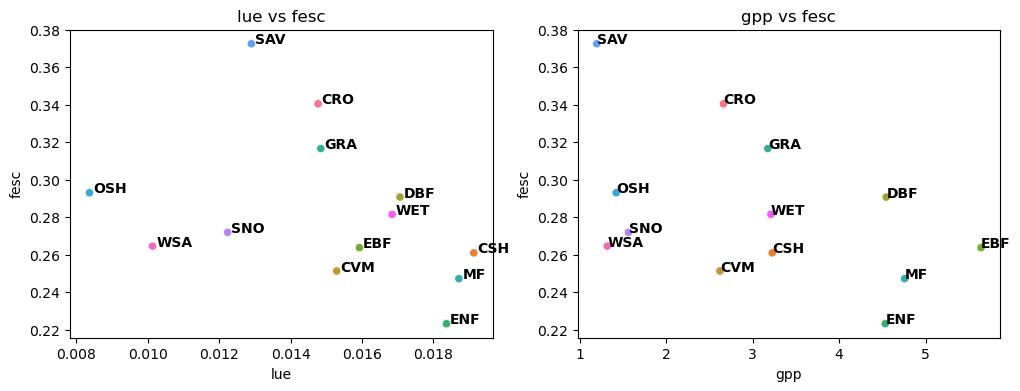

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

x = "lue"
y = "fesc"

df_to_plot = median_values_grouped

scatter = sns.scatterplot(
    data=df_to_plot, x=x, y=y, hue="site_type", ax=ax[0]
)
for line in range(0, df_to_plot.shape[0]):
    scatter.text(
        df_to_plot[x][line] + 0.0001,
        df_to_plot[y][line],
        df_to_plot.index[line],
        horizontalalignment="left",
        size="medium",
        color="black",
        weight="semibold",
    )

ax[0].set_xlabel(x)
ax[0].set_ylabel(y)
ax[0].set_title(x + " vs " + y)
scatter.legend_.remove()

x = "gpp"
y = "fesc"

scatter = sns.scatterplot(data=df_to_plot, x=x, y=y, hue="site_type", ax=ax[1])
for line in range(0, df_to_plot.shape[0]):
    scatter.text(
        df_to_plot[x][line] + 0.001,
        df_to_plot[y][line],
        df_to_plot.index[line],
        horizontalalignment="left",
        size="medium",
        color="black",
        weight="semibold",
    )

ax[1].set_xlabel(x)
ax[1].set_ylabel(y)
ax[1].set_title(x + " vs " + y)

# Remove the legend
scatter.legend_.remove()
plt.savefig("../outputs/figures/lue_fesc_gpp.png")


/tmp/ipykernel_550069/3608781525.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xpos = np.clip(median_values_grouped[x][line] + 0.0001, ax[0].get_xlim()[0], ax[0].get_xlim()[1])
/tmp/ipykernel_550069/3608781525.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ypos = np.clip(median_values_grouped[y][line], ax[0].get_ylim()[0], ax[0].get_ylim()[1])
/tmp/ipykernel_550069/3608781525.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

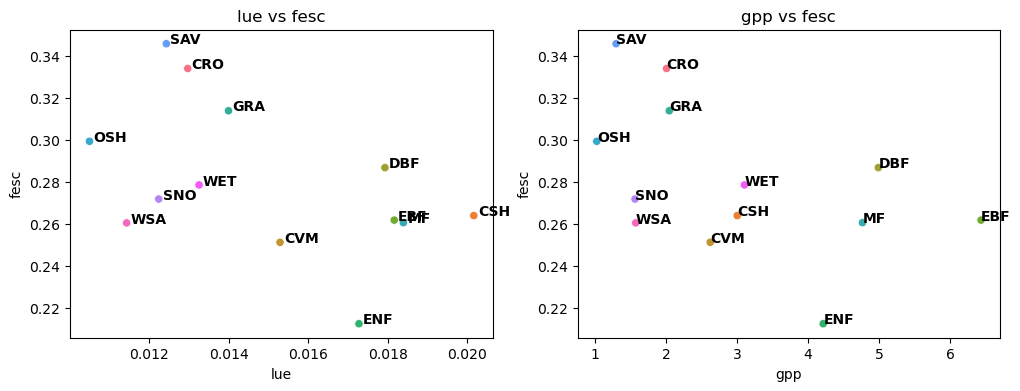

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

x = "lue"
y = "fesc"

scatter = sns.scatterplot(
    data=median_values_grouped, x=x, y=y, hue="site_type", ax=ax[0]
)
for line in range(0, median_values_grouped.shape[0]):
    xpos = np.clip(median_values_grouped[x][line] + 0.0001, ax[0].get_xlim()[0], ax[0].get_xlim()[1])
    ypos = np.clip(median_values_grouped[y][line], ax[0].get_ylim()[0], ax[0].get_ylim()[1])
    scatter.text(
        xpos,
        ypos,
        median_values_grouped.index[line],
        horizontalalignment="left",
        size="medium",
        color="black",
        weight="semibold",
    )

ax[0].set_xlabel(x)
ax[0].set_ylabel(y)
ax[0].set_title(x + " vs " + y)
scatter.legend_.remove()

x = "gpp"
y = "fesc"

scatter = sns.scatterplot(data=median_values_grouped, x=x, y=y, hue="site_type", ax=ax[1])
for line in range(0, median_values_grouped.shape[0]):
    xpos = np.clip(median_values_grouped[x][line] + 0.001, ax[1].get_xlim()[0], ax[1].get_xlim()[1])
    ypos = np.clip(median_values_grouped[y][line], ax[1].get_ylim()[0], ax[1].get_ylim()[1])
    scatter.text(
        xpos,
        ypos,
        median_values_grouped.index[line],
        horizontalalignment="left",
        size="medium",
        color="black",
        weight="semibold",
    )

ax[1].set_xlabel(x)
ax[1].set_ylabel(y)
ax[1].set_title(x + " vs " + y)

# Remove the legend
scatter.legend_.remove()